Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

Before starting to get through the quite tedious code, have a look at this awesome tutorial about word2vec http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/

In [121]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [123]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes, location):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(filename):
        filename, _ = urlretrieve(url + filename, os.path.join(location,filename))
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified %s' % filename)
    else:
        print(statinfo.st_size)
        raise Exception(
          'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

filename = maybe_download('text8.zip', 31344016, 'input')

Found and verified input/text8.zip


Read the data into a string.

In [124]:
def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words"""
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data

words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [125]:
vocabulary_size = 50000

def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    #print(count)
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    #print(dictionary)
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count = unk_count + 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
#del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5243, 3084, 12, 6, 195, 2, 3134, 46, 59, 156]


In [127]:
print("count[2] ", count[data[2]])
print("data[2] ", data[2])
print("words[2] ", words[2])
print("dictionary[words[2]] ", dictionary[words[2]])
print("reverse_dictionary[dictionary[words[2]]] ", reverse_dictionary[dictionary[words[2]]])

count[2]  ('as', 131815)
data[2]  12
words[2]  as
dictionary[words[2]]  12
reverse_dictionary[dictionary[words[2]]]  as


Summary of current variables: 

words - Contains all the words.

data - Contains the indexes mapping the order of words in words to the dictionary.

count - Contains the most common words in order with corresponding counts (except the first one).

dictionary - Contains the words with the word as key.

reverse dictionary - Contains the words with the index as key.

Function to generate a training batch for the skip-gram model.

In [128]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    #print(buffer)
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      #print(i * num_skips + j)
      #print(buffer[skip_window])
      labels[i * num_skips + j, 0] = buffer[target]
    #print(buffer)
    buffer.append(data[data_index])
    #print(data_index)
    data_index = (data_index + 1) % len(data)
    #print(buffer)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])
#print(batch)
#print(labels)

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['anarchism', 'as', 'a', 'originated', 'as', 'term', 'a', 'of']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['term', 'originated', 'a', 'anarchism', 'term', 'originated', 'as', 'of']


Train a skip-gram model.

In [16]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  #print(norm.get_shape())
  #print(embeddings.get_shape())
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings)) # Cosine similarity.
  print(similarity.get_shape())

(16, 50000)


In [71]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.525533
Nearest to for: drawbacks, gernika, shores, navajo, jarrett, sahib, lebesgue, survives,
Nearest to its: hussite, niggers, lap, asked, rope, hexagrams, ophelia, penguin,
Nearest to as: katal, abel, toto, montage, quell, gould, hyperfocal, geddy,
Nearest to zero: allowed, aesthetically, opined, discomfort, dale, infra, unisys, thc,
Nearest to their: madelyne, shoah, aglaulus, carbide, buttocks, shamans, poplar, mutualism,
Nearest to used: gaseous, boxer, reflecting, corvette, northrop, garde, fukuoka, adt,
Nearest to some: haphazard, fichte, happened, weidman, rooney, rickey, nagoya, plates,
Nearest to that: announces, gamba, oz, leclerc, pitfalls, actors, to, joanna,
Nearest to while: flogging, ernesto, searchable, amr, husayn, galvani, andamans, scribe,
Nearest to two: hutch, gting, jen, spoleto, knocks, unadorned, inquisitor, intersex,
Nearest to have: primaries, muscles, interacts, aegina, watches, doubts, pieter, retrieval,
Nearest to kno

Average loss at step 52000: 3.160577
Average loss at step 54000: 3.414804
Average loss at step 56000: 3.429673
Average loss at step 58000: 3.378074
Average loss at step 60000: 3.416988
Nearest to for: gernika, of, mot, campylobacter, punish, navajo, screwtape, in,
Nearest to its: their, his, her, the, freighters, whose, considerable, some,
Nearest to as: neuter, nitrous, like, when, believing, reassessment, while, linear,
Nearest to zero: five, eight, four, six, nine, seven, three, two,
Nearest to their: its, his, her, the, your, some, these, whose,
Nearest to used: known, written, seen, referred, applied, considered, regarded, available,
Nearest to some: many, several, these, most, both, various, other, any,
Nearest to that: which, however, what, this, but, about, actually, fugue,
Nearest to while: although, when, though, however, but, are, montaigne, where,
Nearest to two: three, four, six, five, one, seven, eight, zero,
Nearest to have: had, has, were, are, be, seem, contain, buy,
N

In [75]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

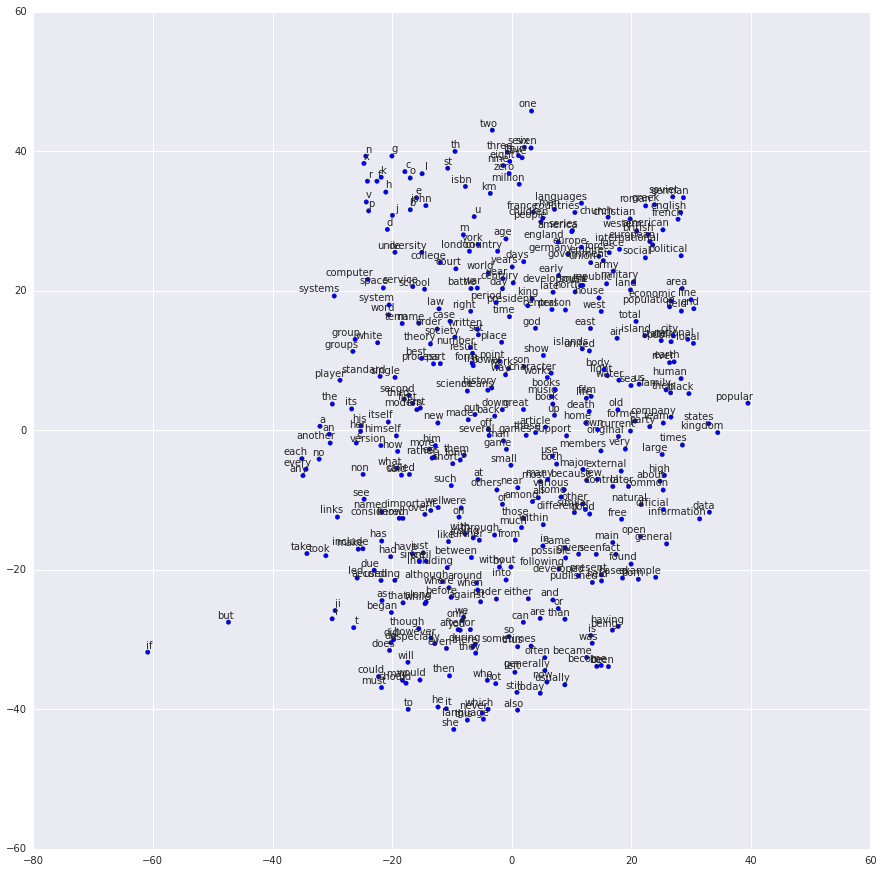

In [0]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

The skip-gram model predicts the context of a word given it as an input. CBOW works the other way around, taking the context of a word, predict the word. Hence we will use the same embedding-layer to create N embeddings given N context words and then sum over the embedding to get an embedding to predict the output word. This means that our variables will not change but we'll have to modify the input to the softmax layer.

First lets modify the batch generator, with 2*bag_window being the number of centext words to consier and num_skips number we actually use.

In [129]:
data_index = 0

def generate_batch(batch_size, num_skips, bag_window):
    global data_index
    span = 2 * bag_window + 1 # The span, including target word.
    assert num_skips <= 2 * skip_window # So the words we'll use is not larger than the words available.
    batch = np.ndarray(shape=(batch_size, num_skips), dtype=np.int32) # Single instance now of length num_skips.
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32) # Single target label.
    
    buffer = collections.deque(maxlen=span) # Queue used for implementation purposes.
    
    # Get words from global data_index to data_index + span (The words used in first instance in batch).
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data) # Circulary increment data_index.

    # Create one instance in batch every iteration.
    for i in range(batch_size): 
        target = bag_window  # Target label at the center of the buffer.
        targets_to_avoid = [bag_window] # The words to avoid in instance.
        index = 0 # Index to keep count of instance inputs.
        for j in range(num_skips): # For the number of words to be used in the instance.
                while target in targets_to_avoid: # While we do not have a new word, randomly draw a new one.
                    target = random.randint(0, span - 1)
                targets_to_avoid.append(target) # Add the word to avoids.
                batch[i,index] = buffer[target] # Add context word.
                index+=1 # Increment index.
        labels[i, 0] = buffer[bag_window] # Add target word to labels.
        buffer.append(data[data_index]) # Append next word pushing out the first one.
        data_index = (data_index + 1) % len(data) # Circulary increment data_index.
    return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, bag_window in [(2, 3), (2, 1)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, bag_window=bag_window)
    print('\nwith num_skips = %d and bag_window = %d:' % (num_skips, bag_window))
    print('    batch:', [[reverse_dictionary[w] for w in bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and bag_window = 3:
    batch: [['anarchism', 'term'], ['abuse', 'of'], ['used', 'a'], ['term', 'used'], ['used', 'of'], ['early', 'working'], ['class', 'first'], ['working', 'radicals']]
    labels: ['a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early']

with num_skips = 2 and bag_window = 1:
    batch: [['as', 'anarchism'], ['a', 'originated'], ['as', 'term'], ['a', 'of'], ['abuse', 'term'], ['first', 'of'], ['used', 'abuse'], ['first', 'against']]
    labels: ['originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used']


Train the cbow model.

In [131]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
bag_window = 3 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size, num_skips])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Variables.
    embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Model.
    # Look up embeddings for inputs.
    embed = tf.zeros([batch_size, embedding_size]) # To hold the embedding, one embedding for each instance.
    for i in range(num_skips): # For each of the num_skips word in each instance.
        # Sum up embedding for each the instance input words.
        embed += tf.nn.embedding_lookup(embeddings, train_dataset[:,i]) 
        
    # embed is now the correct shape of [batch_size, embedding_size] containing the joint embedding given the input
    # instances.
      
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

    # Optimizer.
    # Note: The optimizer will optimize the softmax_weights AND the embeddings.
    # This is because the embeddings are defined as a variable quantity and the
    # optimizer's `minimize` method will by default modify all variable quantities 
    # that contribute to the tensor it is passed.
    # See docs on `tf.train.Optimizer.minimize()` for more details.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
        normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings)) # Cosine similarity.
    print(similarity.get_shape())

(16, 50000)


In [78]:
num_steps = 100001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(batch_size, num_skips, bag_window)        
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Average loss at step 0: 7.423783
Nearest to on: lind, transnistrian, jarre, alters, extremes, unverified, tasty, compactness,
Nearest to war: centro, crtc, marl, entities, ethnology, unleashed, rimet, tico,
Nearest to most: tilden, kinsmen, boost, sled, golems, subspecies, arkham, morning,
Nearest to a: derivates, robotics, disturbed, benitez, calibrate, measuring, depending, unqualified,
Nearest to often: galois, illogical, jokes, beggars, ringworld, hilary, callers, frederik,
Nearest to two: armor, starfish, animations, lynch, disclose, kraftwerk, melissa, linux,
Nearest to his: postman, subsidised, sei, hash, mark, derivates, sport, picatinny,
Nearest to and: akita, guarding, electromechanical, fa, expiration, nutrition, materials, photon,
Nearest to over: memorized, duplicates, sata, johannes, ingredients, frightful, lin, bizkit,
Nearest to which: bragg, contours, agarose, roberts, chimpanzee, bab

Average loss at step 52000: 3.738756
Average loss at step 54000: 3.774335
Average loss at step 56000: 3.664523
Average loss at step 58000: 3.734221
Average loss at step 60000: 3.719555
Nearest to on: upon, sixtus, studded, autumnal, leasing, princely, off, along,
Nearest to war: during, wars, ii, martinique, world, pitts, championship, impacts,
Nearest to most: more, some, many, among, performing, very, xxx, inq,
Nearest to a: another, the, an, any, num, thrive, every, this,
Nearest to often: usually, sometimes, generally, commonly, now, widely, still, they,
Nearest to two: three, four, one, five, six, zero, seven, eight,
Nearest to his: her, their, him, s, its, raphaelite, physica, the,
Nearest to and: including, while, subordinated, advisor, cccc, orbison, oates, of,
Nearest to over: through, datura, intercalary, during, before, under, after, about,
Nearest to which: that, when, where, these, although, betsy, nourishment, rightfully,
Nearest to history: modern, science, early, art, l

In [86]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

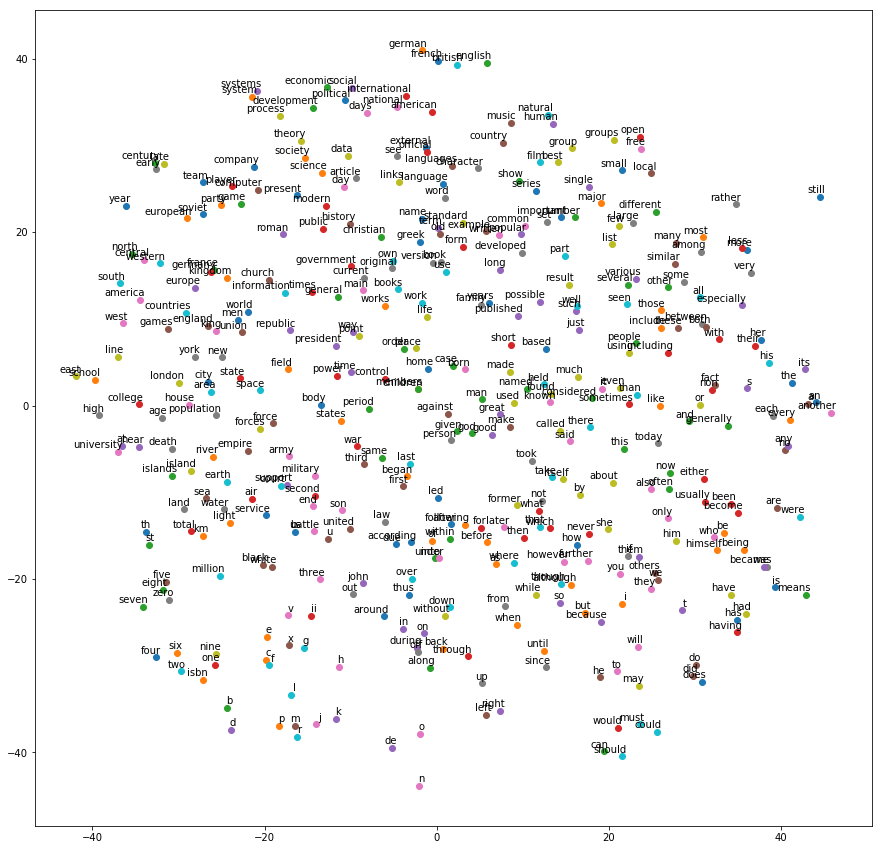

In [89]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
    pylab.show()

words2 = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words2)

For fun, lets have a look at the most similar words to him, man etc and her, woman etc.

In [182]:
def mostsim(word, topk):
    k = dictionary[word]
    manemb = np.array([final_embeddings[k,:]])
    similarity = np.matmul(manemb, np.transpose(final_embeddings)) # Cosine similarity.
    nearest = (-similarity[0, :]).argsort()[1:topk+1]
    log = list()
    for i in range(topk):
        close_word = reverse_dictionary[nearest[i]]
        log.append(close_word)
    return(log)

In [247]:
mwords = ['man', 'he', 'him', 'himself', 'his']
fwords = ['woman', 'she', 'her', 'herself', 'hers']
allwords = list()
allwords.extend(fwords)
allwords.extend(mwords)
mm = list()
ff = list()
for m,f in zip(mwords,fwords):
    mm.extend(mostsim(m,6))
    ff.extend(mostsim(f,6))
mm = [x for x in mm if x not in allwords]
ff = [x for x in ff if x not in allwords]
munique = set(mm)
funique = set(ff)
print(munique)
print(funique)

{'the', 'them', 'charterers', 'curls', 'its', 'they', 's', 'geostationary', 'vidal', 'was', 'being', 'their', 'hoped', 'person', 'vultures', 'encirclement', 'promise', 'rhymed', 'up', 'it', 'unrecorded', 'god', 'gaud'}
{'dflp', 'its', 's', 'trolley', 'draugr', 'gigahertz', 'their', 'bess', 'person', 'never', 'mechanically', 'obnoxious', 'again', 'beef', 'experimented', 'who', 'reactors', 'it', 'deed', 'young', 'cartagena', 'my', 'dramatised', 'shipyard', 'packaging'}
